# Sentiment analysis


Pakin Siwatammarat

## Download data

In [231]:
!curl -O https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/train.txt
!curl -O https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/train_label.txt
!curl -O https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/test.txt
!curl -O https://raw.githubusercontent.com/PyThaiNLP/wisesight-sentiment/master/kaggle-competition/test_label.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5525k  100 5525k    0     0  5525k      0  0:00:01  0:00:01 --:--:-- 4655k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 95216  100 95216    0     0  95216      0  0:00:01 --:--:--  0:00:01  175k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  617k    0  2742    0     0   2742      0  0:

In [232]:
!mkdir data
!move *.txt data/

d:\Dev\ppirch\kbtg-interview\test.txt
d:\Dev\ppirch\kbtg-interview\test_label.txt
d:\Dev\ppirch\kbtg-interview\train.txt
d:\Dev\ppirch\kbtg-interview\train_label.txt
        4 file(s) moved.


## Install library

In [30]:
%pip -q install transformers[torch] sentencepiece pythainlp emoji numpy pandas matplotlib scikit-learn protobuf pytorch-lightning torchtext

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Dev\\ppirch\\kbtg-interview\\env\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Check the permissions.



In [37]:
%pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [ ]:
%pip install fastapi uvicorn[standard]

## Import library

In [787]:
import os
import re
import torch
import pickle
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from pythainlp import word_tokenize
from pythainlp.util import emoji_to_thai
from sklearn import preprocessing
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
torch.manual_seed(13)

In [757]:
warnings.filterwarnings("ignore")
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## Read data

In [758]:
with open('./data/train.txt', encoding="utf8") as f:
  train_texts = [line.strip() for line in f.readlines()]
  f.close()

with open('./data/train_label.txt', encoding="utf8") as f:
  train_labels = [line.strip() for line in f.readlines()]
  f.close()

In [759]:
with open('./data/test.txt', encoding="utf8") as f:
  test_texts = [line.strip() for line in f.readlines()]
  f.close()

with open('./data/test_label.txt', encoding="utf8") as f:
  test_labels = [line.strip() for line in f.readlines()]
  f.close()

In [760]:
# convert from list to pandas 
df = pd.DataFrame({"text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

In [761]:
df.head()

,text,label
0,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,neu
1,คะ,neu
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,neg
3,😅😅😅,neu
4,สวัสดีวันพุธ แนน อะไรนะ,neu


In [762]:
test_df.head()

,text,label
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,neg
1,ครับ #phithanbkk,neu
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,neg
3,Cf clarins 5 ขวด 2850,neu
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,neu


## Class distribution

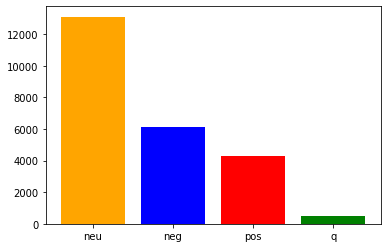

In [763]:
count  = df['label'].value_counts()
plt.bar(count.index, count.values, color=['orange', 'blue', 'red', 'green']);

In [764]:
df['label'].value_counts() / df.shape[0]

neu    0.544612
neg    0.255164
pos    0.178698
q      0.021527
Name: label, dtype: float64

## Label Encoding


In [765]:
le = preprocessing.LabelEncoder()
le.fit(df['label']);

In [766]:
df['label'] = le.transform(df['label'])
test_df['label'] = le.transform(test_df['label'])

In [767]:
label2id = dict(zip(le.classes_, range(len(le.classes_))))
label2id

{'neg': 0, 'neu': 1, 'pos': 2, 'q': 3}

In [768]:
id2label = dict(zip(range(len(le.classes_)), le.classes_))
id2label

{0: 'neg', 1: 'neu', 2: 'pos', 3: 'q'}

In [769]:
with open('./dumps/label2id.pkl', 'wb') as f:
  pickle.dump(label2id, f)

with open('./dumps/id2label.pkl', 'wb') as f:
  pickle.dump(id2label, f)

## Text preprocess

In [770]:
def replace_rep(text):
  def _replace_rep(m):
    c,cc = m.groups()
    return f'{c}xxrep'
  re_rep = re.compile(r'(\S)(\1{2,})')
  return re_rep.sub(_replace_rep, text)

def replace_url(text):
  URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
  return re.sub(URL_PATTERN, 'xxurl', text)

def replace_emoji(text):
  return emoji_to_thai(text, delimiters=(' ', ' '))

def replace_punctuation(text):
  punctuation = string.punctuation.replace(".", "") # remove all punctuation except . because we want to keep infomation some word such as "อ.", "จ." and etc.
  punctuation_translator = str.maketrans('', '', punctuation)
  return text.translate(punctuation_translator)

def preprocess(text):
  preprocess_text = text.lower().strip()
  preprocess_text = replace_url(preprocess_text)
  preprocess_text = replace_rep(preprocess_text)
  # preprocess_text = replace_emoji(preprocess_text)
  preprocess_text = replace_punctuation(preprocess_text)
  return preprocess_text


In [771]:
df['preprocess'] = df['text'].apply(lambda x: preprocess(x))
test_df['preprocess'] = test_df['text'].apply(lambda x: preprocess(x))

In [772]:
df.head()

,text,label,preprocess
0,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,1,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
1,คะ,1,คะ
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,0,อิเหี้ยออมทำกูอยากกินเอ็มเค
3,😅😅😅,1,ยิ้มเหงื่อตก xxrep
4,สวัสดีวันพุธ แนน อะไรนะ,1,สวัสดีวันพุธ แนน อะไรนะ


In [773]:
test_df.head()

,text,label,preprocess
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...
1,ครับ #phithanbkk,1,ครับ phithanbkk
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,0,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...
3,Cf clarins 5 ขวด 2850,1,cf clarins 5 ขวด 2850
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1,ทานได้ค่ะ น้ำซุป mk ต้มมาจากหัวผักกาด ซีอิ้วขา...


In [774]:
counts = Counter()

for index, row in df.iterrows():
    counts.update(word_tokenize(row['preprocess']))

deleting low frequent words

In [775]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 25629
num_words after: 14538


creating vocabulary

In [776]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [777]:
with open("./dumps/vocab2index.pkl", "wb") as f:
    pickle.dump(vocab2index, f)

In [778]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = word_tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [779]:
df['encoded'] = df['preprocess'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
df.head()

,text,label,preprocess,encoded
0,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,1,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ..."
1,คะ,1,คะ,"[[15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,อิเหี้ยออมทำกูอยากกินเอ็มเค,0,อิเหี้ยออมทำกูอยากกินเอ็มเค,"[[16, 17, 18, 19, 20, 21, 22, 23, 24, 0, 0, 0,..."
3,😅😅😅,1,ยิ้มเหงื่อตก xxrep,"[[25, 26, 27, 28, 25, 29, 0, 0, 0, 0, 0, 0, 0,..."
4,สวัสดีวันพุธ แนน อะไรนะ,1,สวัสดีวันพุธ แนน อะไรนะ,"[[30, 31, 32, 25, 33, 25, 34, 35, 0, 0, 0, 0, ..."


In [780]:
test_df['encoded'] = test_df['preprocess'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
test_df.head()

,text,label,preprocess,encoded
0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,0,ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไ...,"[[277, 244, 1092, 411, 222, 62, 133, 25, 411, ..."
1,ครับ #phithanbkk,1,ครับ phithanbkk,"[[174, 25, 11120, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,0,การด่าไปเหมือนได้บรรเทาความเครียดเฉยๆ แต่บีทีเ...,"[[43, 84, 66, 545, 150, 4707, 6883, 681, 39, 2..."
3,Cf clarins 5 ขวด 2850,1,cf clarins 5 ขวด 2850,"[[809, 25, 8012, 25, 270, 25, 1046, 25, 9729, ..."
4,ทานได้ค่ะ น้ำซุป MK ต้มมาจากหัวผักกาด ซีอิ้วขา...,1,ทานได้ค่ะ น้ำซุป mk ต้มมาจากหัวผักกาด ซีอิ้วขา...,"[[1007, 150, 133, 25, 251, 935, 25, 589, 25, 2..."


## Train - Validation Split

In [854]:
X = list(df['encoded'])
y = list(df['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

## Define Dataset and Dataloader

In [855]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [856]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)
test_ds = ReviewsDataset(list(test_df['encoded']), list(test_df['label']))

## Train Model

In [857]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [858]:
def train_model(name, model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(1, epochs+1):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc = validation_metrics(model, val_dl)
        if i % 5 == 0:
            if i == 5: print('-' * 65)
            print('| epoch {:3d} | train loss {:5.3f} | val loss {:5.3f} | val acc {:5.3f} |'.format(i, sum_loss/total, val_loss, val_acc))
            print('-' * 65)
            if not os.path.isdir('./save_weights/{}'.format(name)): os.makedirs('./save_weights/{}'.format(name))
            torch.save(model.state_dict(), './save_weights/{}/epoch_{}.pth'.format(name, i))
            
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long().to(device)
        y = y.long().to(device)
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total

In [859]:
batch_size = 128
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [860]:
class LSTM_Model(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_dim,4)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [861]:
class BILSTM_Model(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.linear1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 4)

    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        x = self.linear1(torch.cat((ht[-2,:,:], ht[-1,:,:]), dim = 1))
        return self.linear2(x)

In [862]:
lstm_model =  LSTM_Model(vocab_size, 300, 256).to(device);
stacked_lstm_model = LSTM_Model(vocab_size, 300, 256, 4).to(device);
bilstm_model =  BILSTM_Model(vocab_size, 300, 256).to(device);
stacked_bilstm_model = BILSTM_Model(vocab_size, 300, 256, 4).to(device);

In [863]:
train_model("lstm", lstm_model, epochs=20, lr=0.001)

-----------------------------------------------------------------
| epoch   5 | train loss 0.879 | val loss 0.959 | val acc 0.618 |
-----------------------------------------------------------------
| epoch  10 | train loss 0.734 | val loss 0.848 | val acc 0.669 |
-----------------------------------------------------------------
| epoch  15 | train loss 0.564 | val loss 0.853 | val acc 0.695 |
-----------------------------------------------------------------
| epoch  20 | train loss 0.424 | val loss 0.898 | val acc 0.690 |
-----------------------------------------------------------------


In [864]:
train_model("stacked_lstm", stacked_lstm_model, epochs=20, lr=0.001)

-----------------------------------------------------------------
| epoch   5 | train loss 0.797 | val loss 0.837 | val acc 0.667 |
-----------------------------------------------------------------
| epoch  10 | train loss 0.518 | val loss 0.789 | val acc 0.704 |
-----------------------------------------------------------------
| epoch  15 | train loss 0.337 | val loss 0.958 | val acc 0.689 |
-----------------------------------------------------------------
| epoch  20 | train loss 0.224 | val loss 1.247 | val acc 0.685 |
-----------------------------------------------------------------


In [865]:
train_model("bilstm", bilstm_model, epochs=20, lr=0.001)

-----------------------------------------------------------------
| epoch   5 | train loss 0.378 | val loss 0.962 | val acc 0.689 |
-----------------------------------------------------------------
| epoch  10 | train loss 0.110 | val loss 1.816 | val acc 0.669 |
-----------------------------------------------------------------
| epoch  15 | train loss 0.072 | val loss 2.113 | val acc 0.673 |
-----------------------------------------------------------------
| epoch  20 | train loss 0.053 | val loss 2.122 | val acc 0.684 |
-----------------------------------------------------------------


In [866]:
train_model("stacked_bilstm", stacked_bilstm_model, epochs=20, lr=0.001)

-----------------------------------------------------------------
| epoch   5 | train loss 0.507 | val loss 0.776 | val acc 0.702 |
-----------------------------------------------------------------
| epoch  10 | train loss 0.209 | val loss 1.163 | val acc 0.693 |
-----------------------------------------------------------------
| epoch  15 | train loss 0.109 | val loss 1.412 | val acc 0.685 |
-----------------------------------------------------------------
| epoch  20 | train loss 0.070 | val loss 1.651 | val acc 0.686 |
-----------------------------------------------------------------


## Load model

Load the most accurate epoch on validation for each model 

In [867]:
lstm_model.load_state_dict(torch.load('./save_weights/lstm/epoch_15.pth', map_location=device))
stacked_lstm_model.load_state_dict(torch.load('./save_weights/stacked_lstm/epoch_10.pth', map_location=device))
bilstm_model.load_state_dict(torch.load('./save_weights/bilstm/epoch_5.pth', map_location=device))
stacked_bilstm_model.load_state_dict(torch.load('./save_weights/stacked_bilstm/epoch_5.pth', map_location=device))

<All keys matched successfully>

## Evaluation

In [868]:
def predict(model, test_dl):
    model.eval()
    predictions = []
    actuals = []
    for x, y, l in test_dl:
        x = x.long().to(device)
        y = y.long().to(device)
        y_hat = model(x, l)
        pred = torch.max(y_hat, 1)[1]
        predictions.extend(pred.detach().cpu().numpy())
        actuals.extend(y.detach().cpu().numpy())
    return predictions, actuals

In [869]:
def evaluation(name, predictions, actuals, target_names = ['neg', 'neu', 'pos', 'q']):
    print(name)
    print(classification_report(actuals, predictions, target_names=target_names))
    f1 = f1_score(actuals, predictions, average='micro')
    cm = confusion_matrix(actuals, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    plt.show()
    return f1

In [870]:
lstm_predictions, lstm_actuals = predict(lstm_model, test_dl)
stacked_lstm_predictions, stacked_lstm_actuals = predict(stacked_lstm_model, test_dl)

bilstm_predictions, bilstm_actuals = predict(bilstm_model, test_dl)
stacked_bilstm_predictions, stacked_bilstm_actuals = predict(stacked_bilstm_model, test_dl)

Stacked LSTM
              precision    recall  f1-score   support

         neg       0.71      0.69      0.70       683
         neu       0.71      0.83      0.76      1456
         pos       0.54      0.35      0.43       478
           q       0.00      0.00      0.00        57

    accuracy                           0.69      2674
   macro avg       0.49      0.47      0.47      2674
weighted avg       0.66      0.69      0.67      2674



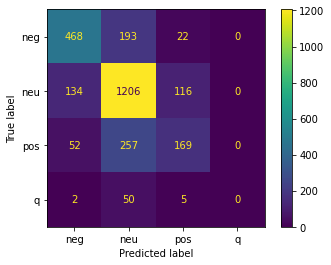

In [871]:
lstm_f1_score = evaluation("Stacked LSTM", lstm_predictions, lstm_actuals)

Stacked LSTM
              precision    recall  f1-score   support

         neg       0.74      0.67      0.70       683
         neu       0.70      0.83      0.76      1456
         pos       0.57      0.41      0.47       478
           q       0.00      0.00      0.00        57

    accuracy                           0.69      2674
   macro avg       0.50      0.48      0.48      2674
weighted avg       0.67      0.69      0.68      2674



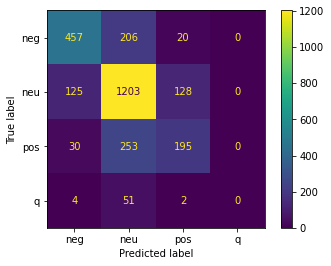

In [872]:
stacked_lstm_f1_score = evaluation("Stacked LSTM", stacked_lstm_predictions, stacked_lstm_actuals)

BILSTM
              precision    recall  f1-score   support

         neg       0.72      0.71      0.72       683
         neu       0.71      0.80      0.75      1456
         pos       0.58      0.38      0.46       478
           q       0.33      0.37      0.35        57

    accuracy                           0.69      2674
   macro avg       0.59      0.56      0.57      2674
weighted avg       0.68      0.69      0.68      2674



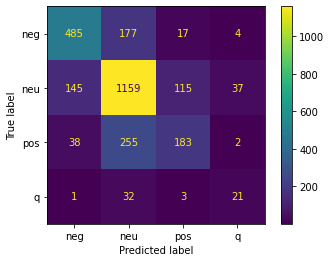

In [873]:
bilstm_f1_score = evaluation("BILSTM", bilstm_predictions, bilstm_actuals)

Stacked BILSTM
              precision    recall  f1-score   support

         neg       0.76      0.69      0.72       683
         neu       0.73      0.79      0.76      1456
         pos       0.57      0.47      0.52       478
           q       0.32      0.44      0.37        57

    accuracy                           0.70      2674
   macro avg       0.60      0.60      0.59      2674
weighted avg       0.70      0.70      0.70      2674



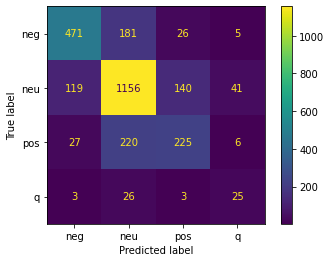

In [874]:
stacked_bilstm_f1_score = evaluation("Stacked BILSTM", stacked_bilstm_predictions, stacked_bilstm_actuals)

## Compare model

In [875]:
micro_f1_score = [lstm_f1_score, bilstm_f1_score, stacked_lstm_f1_score, stacked_bilstm_f1_score]
score_df = pd.DataFrame({'Model': ['LSTM', 'BILSTM', 'Stacked LSTM', 'Stacked BILSTM'], 'F1 Score': micro_f1_score})
score_df

,Model,F1 Score
0,LSTM,0.689230
1,BILSTM,0.691099
2,Stacked LSTM,0.693717
3,Stacked BILSTM,0.701945


Stacked BILSTM is the most accurate model, So I will use this model on API. 